In [1]:
### Importing all the neccessary packages ###
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
from scipy.stats import circmean
from scipy import optimize
import xarray.ufuncs as xu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import seaborn as sns
from scipy.special import rel_entr
from scipy.stats import entropy
from scipy.special import kl_div
from scipy.ndimage import gaussian_filter1d

In [2]:
### Allows us to use dask to speed up some calculations ###
from dask.distributed import Client
client = Client()

distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-nxcgo4q9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-9bs5bmf7', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-h3zvecct', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-ch_cgq6s', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-rxqvjt9q', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-ao8y7a7s', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-wor

In [3]:

def curve(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5):
    output = (a0 +
    a1*np.cos(x/len(x)*2*np.pi) + b1*np.sin(x/len(x)*2*np.pi) + 
    a2*np.cos(x/len(x)*2*np.pi*2) + b2*np.sin(x/len(x)*2*np.pi*2)+ 
    a3*np.cos(x/len(x)*3*np.pi*2) + b3*np.sin(x/len(x)*3*np.pi*2)+
    a4*np.cos(x/len(x)*4*np.pi*2) + b4*np.sin(x/len(x)*4*np.pi*2)+
    a5*np.cos(x/len(x)*5*np.pi*2) + b5*np.sin(x/len(x)*5*np.pi*2))
    
    return output
    
def fit_curve(xdata, ydata):
    guess = [np.mean(ydata), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    params, params_covariance = optimize.curve_fit(curve, xdata, ydata, guess)
    return params, params_covariance

def fourier5(tseries):
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    params, _ = fit_curve(time,tseries)
    return curve(time,*params)
    
    
 

In [3]:
def curve_2harmonic(x, a0, a1, b1, a2, b2):
    output = (a0 +
    a1*np.cos(x/len(x)*2*np.pi) + b1*np.sin(x/len(x)*2*np.pi) + 
    a2*np.cos(x/len(x)*2*np.pi*2) + b2*np.sin(x/len(x)*2*np.pi*2))
    return output

def fit_curve2(xdata, ydata):
    guess = [np.mean(ydata), 0, 0, 0, 0]
    params, params_covariance = optimize.curve_fit(curve_2harmonic, xdata, ydata, guess)
    return params, params_covariance

def fourier2(tseries):
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    params, _ = fit_curve2(time,tseries)
    return curve_2harmonic(time,*params)

In [2]:
data_dir = '/data/deluge/reanalysis/REANALYSIS/ERA5/2D/daily/precip/'

ds = xr.open_mfdataset(data_dir+'*.nc',parallel=True, chunks={'latitude': 25, 'longitude': 25, 'time': -1})


In [3]:
subset=ds.sel(latitude=slice(50,30), longitude=slice((360.0-125),(360.0-65.0)))


In [4]:

start = time.time()



ds_subset = subset
end = time.time()
print(end - start)


0.00011897087097167969


In [5]:
### Changing data to mm and removing leap days ###
ds_subset['precip'].values = ds_subset['precip'].values*1000.0
precip = ds_subset['precip']
precip = precip.sel(time=~((precip.time.dt.month == 2) & (precip.time.dt.day == 29)))

### Calculating the mean precipitation for each grid point
annual_mean_precip = precip.mean(dim='time')

### Calculating the mean annual cycle ###
annual_precip_cycle= precip.groupby('time.dayofyear').mean(dim='time')

annual_precip_cycle_var = precip.groupby('time.dayofyear').std(dim='time')

### Create Daily precip from hourly ###
##daily_precip = precip.resample(time='1D').sum()

### Create The annual daily precip anomalies ###
annual_means = precip.groupby('time.year').mean(dim='time')

anomalies = precip.groupby('time.year') - annual_means
#anomalies = anomalies_withleap.sel(time=~((anomalies_withleap.time.dt.month == 2) & (anomalies_withleap.time.dt.day == 29)))

climDailyMeanAnomaly = annual_precip_cycle - annual_mean_precip

In [8]:
precip.chunk({'time':-1})

<xarray.DataArray 'precip' (time: 25640, latitude: 41, longitude: 121)>
dask.array<xarray-<this-array>, shape=(25640, 41, 121), dtype=float32, chunksize=(25640, 41, 121), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01T15:00:00 ... 2020-03-31T11:00:00
  * longitude  (longitude) float32 235.0 235.5 236.0 236.5 ... 294.0 294.5 295.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 31.5 31.0 30.5 30.0
Attributes:
    long_name:     Total precipitation
    units:         m
    cell_methods:  time: sum

In [6]:
precip['time']= pd.date_range('1950-01-01', periods = 25640)

In [11]:
smoothedPrecipClimatology= xr.apply_ufunc(
    fourier5,
    annual_precip_cycle.load(),
    input_core_dims=[["dayofyear"]],
    exclude_dims=set(["dayofyear"]),
    output_core_dims=[["dayofyear"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)

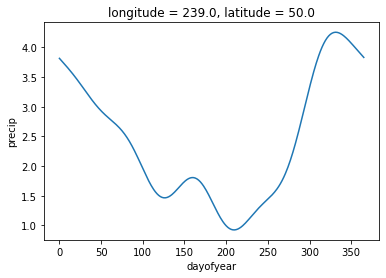

In [12]:
lat = 50
lon = 239

index = annual_precip_cycle.sel(latitude=lat,longitude=lon).dayofyear.values

vals = annual_precip_cycle.sel(latitude=lat,longitude=lon).values


smoothedPrecipClimatology.sel(latitude=lat, longitude=lon).plot()

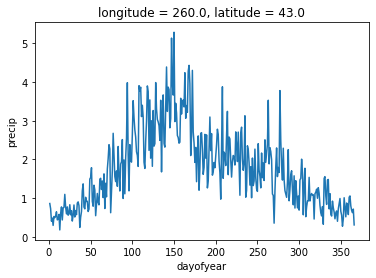

In [13]:
annual_precip_cycle.sel(latitude=lat,longitude=lon).plot()

In [14]:
maxima = signal.find_peaks(smoothedPrecipClimatology.sel(latitude=lat,longitude=lon).values)[0]

minima = signal.find_peaks(-smoothedPrecipClimatology.sel(latitude=lat,longitude=lon).values)[0]

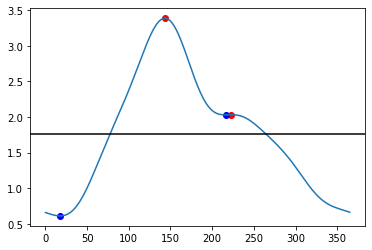

In [15]:
seasonVals = smoothedPrecipClimatology.sel(latitude=lat, longitude=lon).values

plt.plot(np.arange(len(seasonVals)), seasonVals)
plt.scatter(maxima,seasonVals[maxima], color='red')
plt.scatter(minima,seasonVals[minima],color='blue')
plt.axhline(annual_mean_precip.sel(latitude=lat, longitude=lon).values, color='black')

In [13]:


def calcSeasonality(smoothedPrecipClim):
    try:
        IDPMinimaLoc = np.nan
        meanPrecipClim = np.mean(smoothedPrecipClim)
        #print(meanPrecipClim)
        ### Find the minimum before the largest peak and shift data for analysis ###
        shiftVal = np.argmin(smoothedPrecipClim[0:np.argmax(smoothedPrecipClim)])

        smoothedPrecipClimShifted = np.roll(smoothedPrecipClim,-shiftVal)

        maximaLocs = signal.find_peaks(smoothedPrecipClimShifted, height=meanPrecipClim, prominence=0.25)[0]
        #if (maximaLocs.size == 0):
        #   maximaLocs = signal.find_peaks(smoothedPrecipClimShifted, height=meanPrecipClim)[0]
    
            

        minimaLocs = signal.find_peaks(-smoothedPrecipClimShifted, prominence=0.25)[0]
        maximaHeights = smoothedPrecipClimShifted[maximaLocs]
        minimaHeights = smoothedPrecipClimShifted[minimaLocs]

        ### Analysis start is 50 days before minima###
        ### We shift to the minima so it's then missed by peak/valley finding ###

        analysisStart = (shiftVal-50)

        ### Analysis end is 50 days after final maxima, this is unsorted by size###
        finalPeak = np.max(maximaLocs)

        analysisEnd = (finalPeak + 100)+shiftVal

        if analysisStart > analysisEnd:
            analysisStart = analysisStart - 365

        ### Need to sort to get largest peaks, last items are largest ###
        idx   = np.argsort(maximaHeights)

        maximaHeights = maximaHeights[idx]
        maximaLocs = maximaLocs[idx]

        ### Sort the Mins ###
        idn = np.argsort(minimaHeights)

        minimaHeights = minimaHeights[idn]
        minimaLocs = minimaLocs[idn]


        ### Find height of largest peak ###
        peakOne = maximaHeights[-1]
        #analysisStart = minimaLocs[0] - 50

        ### Find minima between two highest peaks ###

        ### Need to check if there are multiple peaks ###
        if len(maximaLocs)>=2:

            ### Construct search to find minima between two largest peaks ###
            minSearch = ((maximaLocs[-1]<minimaLocs) & (minimaLocs<maximaLocs[-2])) | ((maximaLocs[-2]<minimaLocs) & (minimaLocs<maximaLocs[-1]))
            ### Get height of 2nd peak ###
            peakTwo = maximaHeights[-2]

            ### Get the location of the valley between two highest peaks ###
            #print(maximaLocs)
            #print(minimaLocs)
            IDPMinimaLoc = minimaLocs[minSearch][0]
            IDPMinimaVal = minimaHeights[minSearch][0]
            ### Determine if the intermittent period is distinct or subtle
            IDPDistinct = IDPMinimaVal < (meanPrecipClim - 0.75) ### If Minima is 1mm lower than mean annual rainfall

            ### Maximum difference between peaks
            peakDiff = np.max([[peakOne - IDPMinimaVal],[peakTwo-IDPMinimaVal]])

            ### Maximum of the location is the last peak, this only works if we shift the seasonal cycle ###
            lastPeak = np.max([maximaLocs[-2],maximaLocs[-1]])
            firstPeak = np.min([maximaLocs[-2],maximaLocs[-1]])

            ### Intermittent Dry Period (IDP) is inb
            IDPPeriod = (((IDPMinimaLoc - firstPeak)/2 +firstPeak), ((lastPeak - IDPMinimaLoc)/2+IDPMinimaLoc))

            IDPMinimaLoc = IDPMinimaLoc + shiftVal

            




        #wetWindow = (anal,IDPMinimaLoc)
        #dryWindow = (IDPMinimaLoc,400)



        seasonClass=1.0
        if (len(maximaLocs) <= 1):

            seasonClass = 1.0 ### Unimodal Dual Maximum
            #analysisStart = (minimaLocs[0])%366
            wetWindow = (analysisStart,analysisEnd)
            #dryWindow = (IDPMinimaLoc,analysisEnd)


        elif (peakDiff > .5 and IDPDistinct):
            seasonClass = 2.0 ### Bimodal
            wetWindow = (analysisStart,IDPMinimaLoc)
            dryWindow = (IDPMinimaLoc,analysisEnd)

        elif (peakDiff > .5 and IDPDistinct != True):
            seasonClass = 1.5
            wetWindow = (analysisStart,IDPMinimaLoc)
            dryWindow = (IDPMinimaLoc,analysisEnd)
            
        return np.array([seasonClass, analysisStart, analysisEnd, IDPMinimaLoc])
    except Exception:
        return np.array([np.nan, np.nan, np.nan, np.nan])
      #  print(type(inst))    # the exception instance
      #  print(inst.args)     # arguments stored in .args
      #  print(inst)      
      #  return np.nan
    
      


In [14]:
seasonality = xr.apply_ufunc(
calcSeasonality,
smoothedPrecipClimatology,
input_core_dims=[["dayofyear"]],
exclude_dims=set(["dayofyear"]),
output_core_dims=[["params"]],
vectorize=True,
dask = 'parallelized',
output_dtypes = ['float64'],
output_sizes={"params": 4},
)

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  # Remove the CWD from sys.path while we load stuff.


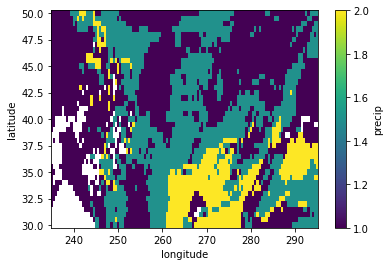

In [15]:
seasonality.isel(params=0).plot()

NameError: name 'analysisStart' is not defined

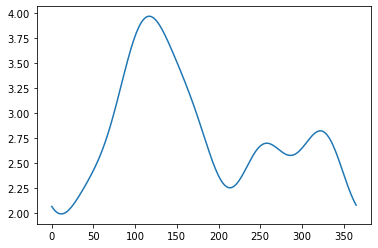

In [40]:
plt.plot(seasonVals)
plt.scatter(analysisStart,smoothedPrecipClim[analysisStart], color='red')
plt.scatter(analysisEnd%365,smoothedPrecipClim[analysisEnd%365],color='blue')
#plt.scatter(IDPMinimaLoc,smoothedPrecipClim[IDPMinimaLoc],color='green')
plt.axhline(annual_mean_precip.sel(latitude=lat, longitude=lon).values, color='black')

#if IDPPeriod:
plt.axvspan(analysisStart,analysisEnd, color='yellow', alpha=0.2)

In [42]:

dataPoint = precip.sel(latitude=lat, longitude=lon)


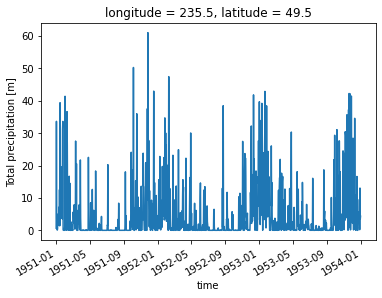

In [45]:
dataPoint.sel(time=slice('1951','1953')).plot()

In [16]:
processInterannual(inputData,time,seasonality):
    
    ### Get parameters from array ###
    seasonClass = seasonality[0]
    analysisStart = seasonality[1]
    analysisEnd = seasonality[2]
    
    IDPMinimaLoc = seasonality[3] #Location of the intermittent dry period center
    
    #Get the number of years, first and last will likely be NaNs
    dataYears = np.unique(time.astype('datetime64[Y]'))
    
    ### Create datetime index, this is probably computationally expensive
    time = pd.DatetimeIndex(time)
    
    ### Create datas tructure to hold results
    firstWetSeason = np.empty([len(dataYears),2], dtype='datetime64[D]')
    #secondWetSeason = np.empty([len(dataYears),2])

    firstWetSeason[:] = np.nan
    #secondWetSeason[:] = np.nan

    for idx, years in enumerate(dataYears):
        
        year = pd.to_datetime(str(years)) ### Not sure this is necessary
        
        ### Do some date math
        startAnalysis = (year +pd.Timedelta(analysisStart, unit='day')).date()
        endAnalysis = (year + pd.Timedelta(analysisEnd, unit='day')).date()
        
        ### Date range of analysis ###
        dateRange = pd.date_range(start=startAnalysis,end=endAnalysis, freq='D')
        #print(time[time==dateRange])
        
        if np.isin(dateRange,time).all():
            data = inputData[np.isin(time,dateRange)]
            data[data<.001] = 0
        else:
            output[idx,:] = np.nan, np.nan
            continue

        if (seasonClass == 1.0):


            dataAnom= data - data.mean()
            dataFiltered = gaussian_filter1d(data, sigma=3)
            cumsumData = np.cumsum(dataAnom)

            cumMin = np.argmin(cumsumData)
            cumMax = np.argmax(cumsumData)
            demiseCutoff = np.quantile(dataFiltered,.33)
            onsetCutoff = 0

            minima = signal.find_peaks(-dataFiltered)[0]

            demiseCandidates = minima[dataFiltered[minima] < demiseCutoff]
            onsetCandidates = minima[dataFiltered[minima] > onsetCutoff]
            try:
                onset = onsetCandidates[onsetCandidates <= cumMin].max()
            except ValueError:

                dataException = dataFiltered[0:cumMin]
                onsetSlice = dataException[dataException <= np.quantile(dataFiltered,.25)]
                if onsetSlice.size == 0:
                    onset = cumMax
                else:
                    onset = np.where(dataFiltered == onsetSlice[0])[0][0]


            try:
                demise = demiseCandidates[demiseCandidates >= cumMax].min()
            except ValueError:

                dataException = dataFiltered[cumMax:-1]
                demiseSlice = dataException[dataException <= np.quantile(dataFiltered,.25)]
                if demiseSlice.size == 0:
                    demise = cumMax
                else:
                    demise = np.where(dataFiltered == demiseSlice[0])[0][0]
            print(onset)
            onsetDate = data['time'][onset].values
            demiseDate = data['time'][demise].values
            firstWetSeason[idx,:] = onsetDate, demiseDate 


        if (seasonClass == 1.5):
            IDPDate = (year + pd.Timedelta(IDPMinimaLoc, unit='day')).date()

            ERSDates = pd.date_range(start=startAnalysis,end=IDPDate, freq='D')
            ERSData =  inputData[np.isin(time,ERSDates)]

            ### This is providing the wrong demise sometimes ###
            LRSDates = pd.date_range(start=IDPDate ,end=endAnalysis, freq='D')
            LRSData =  inputData[np.isin(time,LRSDates)]


            ERSAnom = ERSData - ERSData.mean()
            LRSAnom = LRSData - LRSData.mean()

            dataFiltered = gaussian_filter1d(data, sigma=3)
            ERSAnomCumul = np.cumsum(ERSAnom.values)
            LRSAnomCumul = np.cumsum(LRSAnom.values)

            cumMin = np.argmin(ERSAnomCumul)
            ### The argmax of the LRS will the index of only LRS, need to add len(ERS) to get right point in the full data ###
            cumMax = np.argmax(LRSAnomCumul) + len(ERSAnomCumul)

            demiseCutoff = np.quantile(dataFiltered,.33)
            onsetCutoff = 0

            minima = signal.find_peaks(-dataFiltered)[0]

            demiseCandidates = minima[dataFiltered[minima] < demiseCutoff]
            onsetCandidates = minima[dataFiltered[minima] > onsetCutoff]

            try:
                onset = onsetCandidates[onsetCandidates <= cumMin].max()
            except ValueError:

                dataException = dataFiltered[0:cumMin]
                onsetSlice = dataException[dataException <= np.quantile(dataFiltered,.25)]
                if onsetSlice.size == 0:
                    onset = cumMax
                else:
                    onset = np.where(dataFiltered == onsetSlice[0])[0][0]


            try:
                demise = demiseCandidates[demiseCandidates >= cumMax].min()
            except ValueError:

                dataException = dataFiltered[cumMax:-1]
                demiseSlice = dataException[dataException <= np.quantile(dataFiltered,.25)]
                if demiseSlice.size == 0:
                    demise = cumMax
                else:
                    demise = np.where(dataFiltered == demiseSlice[0])[0][0]
            #onset = onsetCandidates[onsetCandidates <= cumMin].max()
            #demise = demiseCandidates[demiseCandidates >= cumMax].min()
            onsetDate = data['time'][onset].values
            demiseDate = data['time'][demise].values
            firstWetSeason[idx,:] = onsetDate, demiseDate 

        #print(str(years)+': '+'['+str(onset)+','+str(demise)+']')
        #print(data)
        #print(firstWetSeason)
    return firstWetSeason

SyntaxError: invalid syntax (875249236.py, line 1)

In [155]:
np.array(['1951-01-01',pd.NaT], dtype='datetime64[D]')

ValueError: cannot convert float NaN to integer

In [20]:
def processInterannual(inputData,time,seasonality):

    ### Get parameters from array ###
    seasonClass = seasonality[0]
    analysisStart = seasonality[1]
    analysisEnd = seasonality[2]
    
    IDPMinimaLoc = seasonality[3] #Location of the intermittent dry period center

    #Get the number of years, first and last will likely be NaNs

    ### Create datetime index, this is probably computationally expensive
    time = pd.to_datetime(time)
    dataYears = time.year.unique()
    #dataYears = dataYears.astype('datetime64[D]')

    ### Create datas tructure to hold results
    firstWetSeason = np.empty([len(dataYears),2], dtype='datetime64[D]')
    #secondWetSeason = np.empty([len(dataYears),2])

    firstWetSeason[:] = None
    #secondWetSeason[:] = np.nan

    ### Check if the important values are nans ###
    if np.isnan(seasonality[0:3]).any():
        return 

        ### Process each year ###
    for idx, years in enumerate(dataYears):

        
        year = pd.to_datetime(str(years)) ### Not sure this is necessary

        ### Do some date math to get analysis period
        startAnalysis = (year + pd.to_timedelta(analysisStart, unit='day')).date()
        endAnalysis = (year + pd.Timedelta(analysisEnd, unit='day')).date()
        dateRange = pd.date_range(start=startAnalysis,end=endAnalysis, freq='D') ### Analysis period
        
        ### If the analysis period is not full within the data time period, skip (returning nan by default) ###
        if np.isin(dateRange,time).all():
            
            data = inputData[np.isin(time,dateRange)]
            data[data<.001] = 0
            #print(len(dateRange))
        else:
            continue
        
        ### Unimodal ###
        if (seasonClass == 1.0):


            dataAnom = data - data.mean()
            dataFiltered = gaussian_filter1d(data, sigma=3)
            cumsumData = np.cumsum(dataAnom)

            cumMin = np.argmin(cumsumData)
            cumMax = np.argmax(cumsumData)
            demiseCutoff = np.quantile(dataFiltered,.33)
            onsetCutoff = 0

            minima = signal.find_peaks(-dataFiltered)[0]

            demiseCandidates = minima[dataFiltered[minima] < demiseCutoff]
            onsetCandidates = minima[dataFiltered[minima] > onsetCutoff]
            try:
                onset = onsetCandidates[onsetCandidates <= cumMin].max()
            except ValueError:

                dataException = dataFiltered[0:cumMin]
                onsetSlice = dataException[dataException <= np.quantile(dataFiltered,.25)]
                if onsetSlice.size == 0:
                    onset = cumMax
                else:
                    onset = np.where(dataFiltered == onsetSlice[0])[0][0]


            try:
                demise = demiseCandidates[demiseCandidates >= cumMax].min()
            except ValueError:

                dataException = dataFiltered[cumMax:-1]
                demiseSlice = dataException[dataException <= np.quantile(dataFiltered,.25)]
                if demiseSlice.size == 0:
                    demise = cumMax
                else:
                    demise = np.where(dataFiltered == demiseSlice[0])[0][0]
            #print(dateRange[onset])
            onsetDate = dateRange[onset]
            demiseDate = dateRange[demise]

            firstWetSeason[idx,:] = onsetDate, demiseDate 

        ### Unimodal Dual Maximum ###
        if (seasonClass == 1.5):
            IDPDate = (year + pd.Timedelta(IDPMinimaLoc, unit='day')).date()

            ERSDates = pd.date_range(start=startAnalysis,end=IDPDate, freq='D')
            ERSData =  inputData[np.isin(time,ERSDates)]

            ### This is providing the wrong demise sometimes ###
            LRSDates = pd.date_range(start=IDPDate ,end=endAnalysis, freq='D')
            LRSData =  inputData[np.isin(time,LRSDates)]


            ERSAnom = ERSData - ERSData.mean()
            LRSAnom = LRSData - LRSData.mean()

            dataFiltered = gaussian_filter1d(data, sigma=3)
            ERSAnomCumul = np.cumsum(ERSAnom)
            LRSAnomCumul = np.cumsum(LRSAnom)

            cumMin = np.argmin(ERSAnomCumul)
            ### The argmax of the LRS will the index of only LRS, need to add len(ERS) to get right point in the full data ###
            cumMax = np.argmax(LRSAnomCumul) + len(ERSAnomCumul)

            demiseCutoff = np.quantile(dataFiltered,.33)
            onsetCutoff = 0

            minima = signal.find_peaks(-dataFiltered)[0]

            demiseCandidates = minima[dataFiltered[minima] < demiseCutoff]
            onsetCandidates = minima[dataFiltered[minima] > onsetCutoff]

            try:
                onset = onsetCandidates[onsetCandidates <= cumMin].max()
            except ValueError:

                dataException = dataFiltered[0:cumMin]
                onsetSlice = dataException[dataException <= np.quantile(dataFiltered,.25)]
                if onsetSlice.size == 0:
                    onset = cumMax
                else:
                    onset = np.where(dataFiltered == onsetSlice[0])[0][0]


            try:
                demise = demiseCandidates[demiseCandidates >= cumMax].min()
            except ValueError:

                dataException = dataFiltered[cumMax:-1]
                demiseSlice = dataException[dataException <= np.quantile(dataFiltered,.25)]
                if demiseSlice.size == 0:
                    demise = cumMax
                else:
                    demise = np.where(dataFiltered == demiseSlice[0])[0][0]
            #onset = onsetCandidates[onsetCandidates <= cumMin].max()
            #demise = demiseCandidates[demiseCandidates >= cumMax].min()
            onsetDate = dateRange[onset-1]
            demiseDate = dateRange[demise-1]
            firstWetSeason[idx,:] = onsetDate, demiseDate 


    return firstWetSeason[:,1]

In [67]:
seasonality = seasonality.assign_coords({'params':[0,1,2,3]})

In [21]:
%time
demise = xr.apply_ufunc(
processInterannual,
precip,
precip['time'],
seasonality,
input_core_dims=(['time'],['time'],['params']),
exclude_dims=set(['time','params']),
output_core_dims=[['year']],
vectorize=True,
dask = 'allowed',
#output_dtypes = ['datetime64'],
output_sizes={"year": 71},
)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 21.9 µs


In [19]:
onset

<xarray.DataArray (latitude: 41, longitude: 121, year: 71)>
array([[['1950-09-12T00:00:00.000000000',
         '1951-09-17T00:00:00.000000000',
         '1952-10-08T00:00:00.000000000', ...,
         '2018-08-12T00:00:00.000000000',
                                   'NaT',
                                   'NaT'],
        ['1950-09-13T00:00:00.000000000',
         '1951-09-16T00:00:00.000000000',
         '1952-10-08T00:00:00.000000000', ...,
         '2018-08-13T00:00:00.000000000',
                                   'NaT',
                                   'NaT'],
        ['1950-09-12T00:00:00.000000000',
         '1951-09-16T00:00:00.000000000',
         '1952-10-09T00:00:00.000000000', ...,
         '2018-08-15T00:00:00.000000000',
                                   'NaT',
                                   'NaT'],
        ...,
        [                          'NaT',
...
                                   'NaT'],
        ...,
        ['1950-05-12T00:00:00.000000000',
         '1951-05-01T00:00:00.000000000',
         '1952-04-18T00:00:00.000000000', ...,
         '2018-06-03T00:00:00.000000000',
         '2019-07-16T00:00:00.000000000',
                                   'NaT'],
        ['1950-05-12T00:00:00.000000000',
         '1951-05-01T00:00:00.000000000',
         '1952-03-31T00:00:00.000000000', ...,
         '2018-05-22T00:00:00.000000000',
         '2019-07-17T00:00:00.000000000',
                                   'NaT'],
        ['1950-05-12T00:00:00.000000000',
         '1951-05-02T00:00:00.000000000',
         '1952-03-31T00:00:00.000000000', ...,
         '2018-05-21T00:00:00.000000000',
         '2019-04-04T00:00:00.000000000',
                                   'NaT']]], dtype='datetime64[ns]')
Coordinates:
  * longitude  (longitude) float32 235.0 235.5 236.0 236.5 ... 294.0 294.5 295.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 31.5 31.0 30.5 30.0
Dimensions without coordinates: year

In [24]:
onset.name = 'onset_date'
demise.name = 'demise_date'
onset.coords['year'] = pd.date_range("1950", periods=71, freq='YS')
demise.coords['year'] = pd.date_range("1950", periods=71, freq='YS')
test_onset = xr.merge([onset,demise])
test_onset['demise_doy'] = test_onset['demise_date'].dt.dayofyear
test_onset['onset_doy'] = test_onset['onset_date'].dt.dayofyear

In [26]:
test_onset.to_netcdf('martinezOnsetDemise_ERA5.nc')

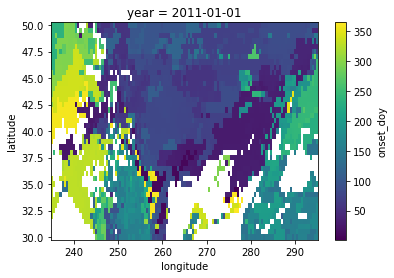

In [75]:
test_onset['onset_doy'].isel(year=60).plot()

In [178]:
mapped = xr.map_blocks(processInterannual,precip, template=template)

In [173]:
template = precip.isel(time=slice(0,69))

In [ ]:
test2 = mapped.load(scheduler="threads")

In [149]:
precip = precip.chunk({'latitude':10,'longitude':10,'time':-1})

In [160]:
test2

<xarray.DataArray (dim_0: 69, dim_1: 2)>
array([['1951-04-06T00:00:00.000000000', '1951-09-07T00:00:00.000000000'],
       ['1952-04-25T00:00:00.000000000', '1952-07-24T00:00:00.000000000'],
       ['1953-04-15T00:00:00.000000000', '1953-08-17T00:00:00.000000000'],
       ['1954-05-08T00:00:00.000000000', '1954-09-07T00:00:00.000000000'],
       ['1955-05-08T00:00:00.000000000', '1955-09-06T00:00:00.000000000'],
       ['1956-03-11T00:00:00.000000000', '1956-09-08T00:00:00.000000000'],
       ['1957-03-17T00:00:00.000000000', '1957-09-09T00:00:00.000000000'],
       ['1958-02-16T00:00:00.000000000', '1958-08-04T00:00:00.000000000'],
       ['1959-04-02T00:00:00.000000000', '1959-07-23T00:00:00.000000000'],
       ['1960-05-06T00:00:00.000000000', '1960-08-29T00:00:00.000000000'],
       ['1961-04-13T00:00:00.000000000', '1960-12-10T00:00:00.000000000'],
       ['1962-04-28T00:00:00.000000000', '1962-07-23T00:00:00.000000000'],
       ['1963-03-23T00:00:00.000000000', '1963-09-06T00:00:00.000000000'],
       ['1964-03-07T00:00:00.000000000', '1964-09-03T00:00:00.000000000'],
       ['1965-03-27T00:00:00.000000000', '1965-07-22T00:00:00.000000000'],
       ['1966-02-19T00:00:00.000000000', '1966-09-05T00:00:00.000000000'],
       ['1967-03-29T00:00:00.000000000', '1967-08-26T00:00:00.000000000'],
       ['1968-02-29T00:00:00.000000000', '1968-09-07T00:00:00.000000000'],
       ['1969-04-17T00:00:00.000000000', '1969-07-23T00:00:00.000000000'],
       ['1970-03-29T00:00:00.000000000', '1970-06-28T00:00:00.000000000'],
...
       ['2001-03-10T00:00:00.000000000', '2001-07-24T00:00:00.000000000'],
       ['2002-03-27T00:00:00.000000000', '2001-11-30T00:00:00.000000000'],
       ['2003-03-27T00:00:00.000000000', '2003-07-05T00:00:00.000000000'],
       ['2004-04-20T00:00:00.000000000', '2004-09-10T00:00:00.000000000'],
       ['2005-04-15T00:00:00.000000000', '2005-06-29T00:00:00.000000000'],
       ['2006-02-16T00:00:00.000000000', '2005-11-26T00:00:00.000000000'],
       ['2007-03-05T00:00:00.000000000', '2007-06-14T00:00:00.000000000'],
       ['2008-03-17T00:00:00.000000000', '2008-08-08T00:00:00.000000000'],
       ['2009-02-28T00:00:00.000000000', '2009-08-27T00:00:00.000000000'],
       ['2010-04-01T00:00:00.000000000', '2010-08-07T00:00:00.000000000'],
       ['2011-03-20T00:00:00.000000000', '2011-08-26T00:00:00.000000000'],
       ['2012-03-19T00:00:00.000000000', '2012-08-13T00:00:00.000000000'],
       ['2013-03-13T00:00:00.000000000', '2013-08-11T00:00:00.000000000'],
       ['2014-04-02T00:00:00.000000000', '2014-09-05T00:00:00.000000000'],
       ['2015-04-14T00:00:00.000000000', '2015-08-12T00:00:00.000000000'],
       ['2016-03-21T00:00:00.000000000', '2016-08-27T00:00:00.000000000'],
       ['2017-05-17T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
       ['2018-04-15T00:00:00.000000000', '2018-07-22T00:00:00.000000000'],
       ['2019-03-06T00:00:00.000000000', '2019-09-04T00:00:00.000000000']],
      dtype='datetime64[ns]')
Dimensions without coordinates: dim_0, dim_1

In [ ]:
from dask import compute, delayed
#precip.sel(latitude=i[0], longitude=i[1])
futures = []
big_future = client.scatter(big_data)
for i in zip(pairs[0],pairs[1]):
    y =
    future = client.submit(processInterannual, )
    futures.append(future)


#results = dask.compute(*computations, scheduler='distributed',
                       #num_workers=4)

In [ ]:
futs = []
# to avoid the while loop
for i in range(0, min(10, len(df_1))):
    new_df_1 = df_1.iloc[i]
    for j in range(0, len(df_2)):
        new_df_2 = df_2.iloc[j]

        # this will submit future and proceed with the code without
        # waiting for the result
        fut = client.submit(self.func, i, new_df_1, new_df_2, scheduler="processes")
        futs.append(fut)

results = client.gather(futs)

In [ ]:
outputDF = pd.DataFrame(output, columns=['onset','demise'], index=dataYears)

In [7]:
lat = 48.0
lon = 255.0
data = precip.sel(latitude=lat, longitude=lon, time='2011')

In [8]:

dataAnom = data - data.mean()
dataFiltered = gaussian_filter1d(data, sigma=3)
cumsumData = np.cumsum(dataAnom.values)


#maxima = signal.find_peaks(dataFiltered)[0]

#minima = signal.find_peaks(-dataFiltered)[0]

#minima = minima[minima < np.argmin(cumsumData)].max()

#maxima = maxima[maxima > np.argmax(cumsumData)].min()

In [9]:
martinez = xr.open_dataset('martinezOnsetDemise_ERA5.nc')
bombardi = xr.open_dataset('bombardiOnsetDemise_ERA5.nc')

In [88]:
bombardi.sel(latitude=lat, longitude=lon, year='2011')['onset_doy'].values[0]

264.0

In [91]:
dataFiltered[264]

5.8120112

In [96]:
monset

234

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


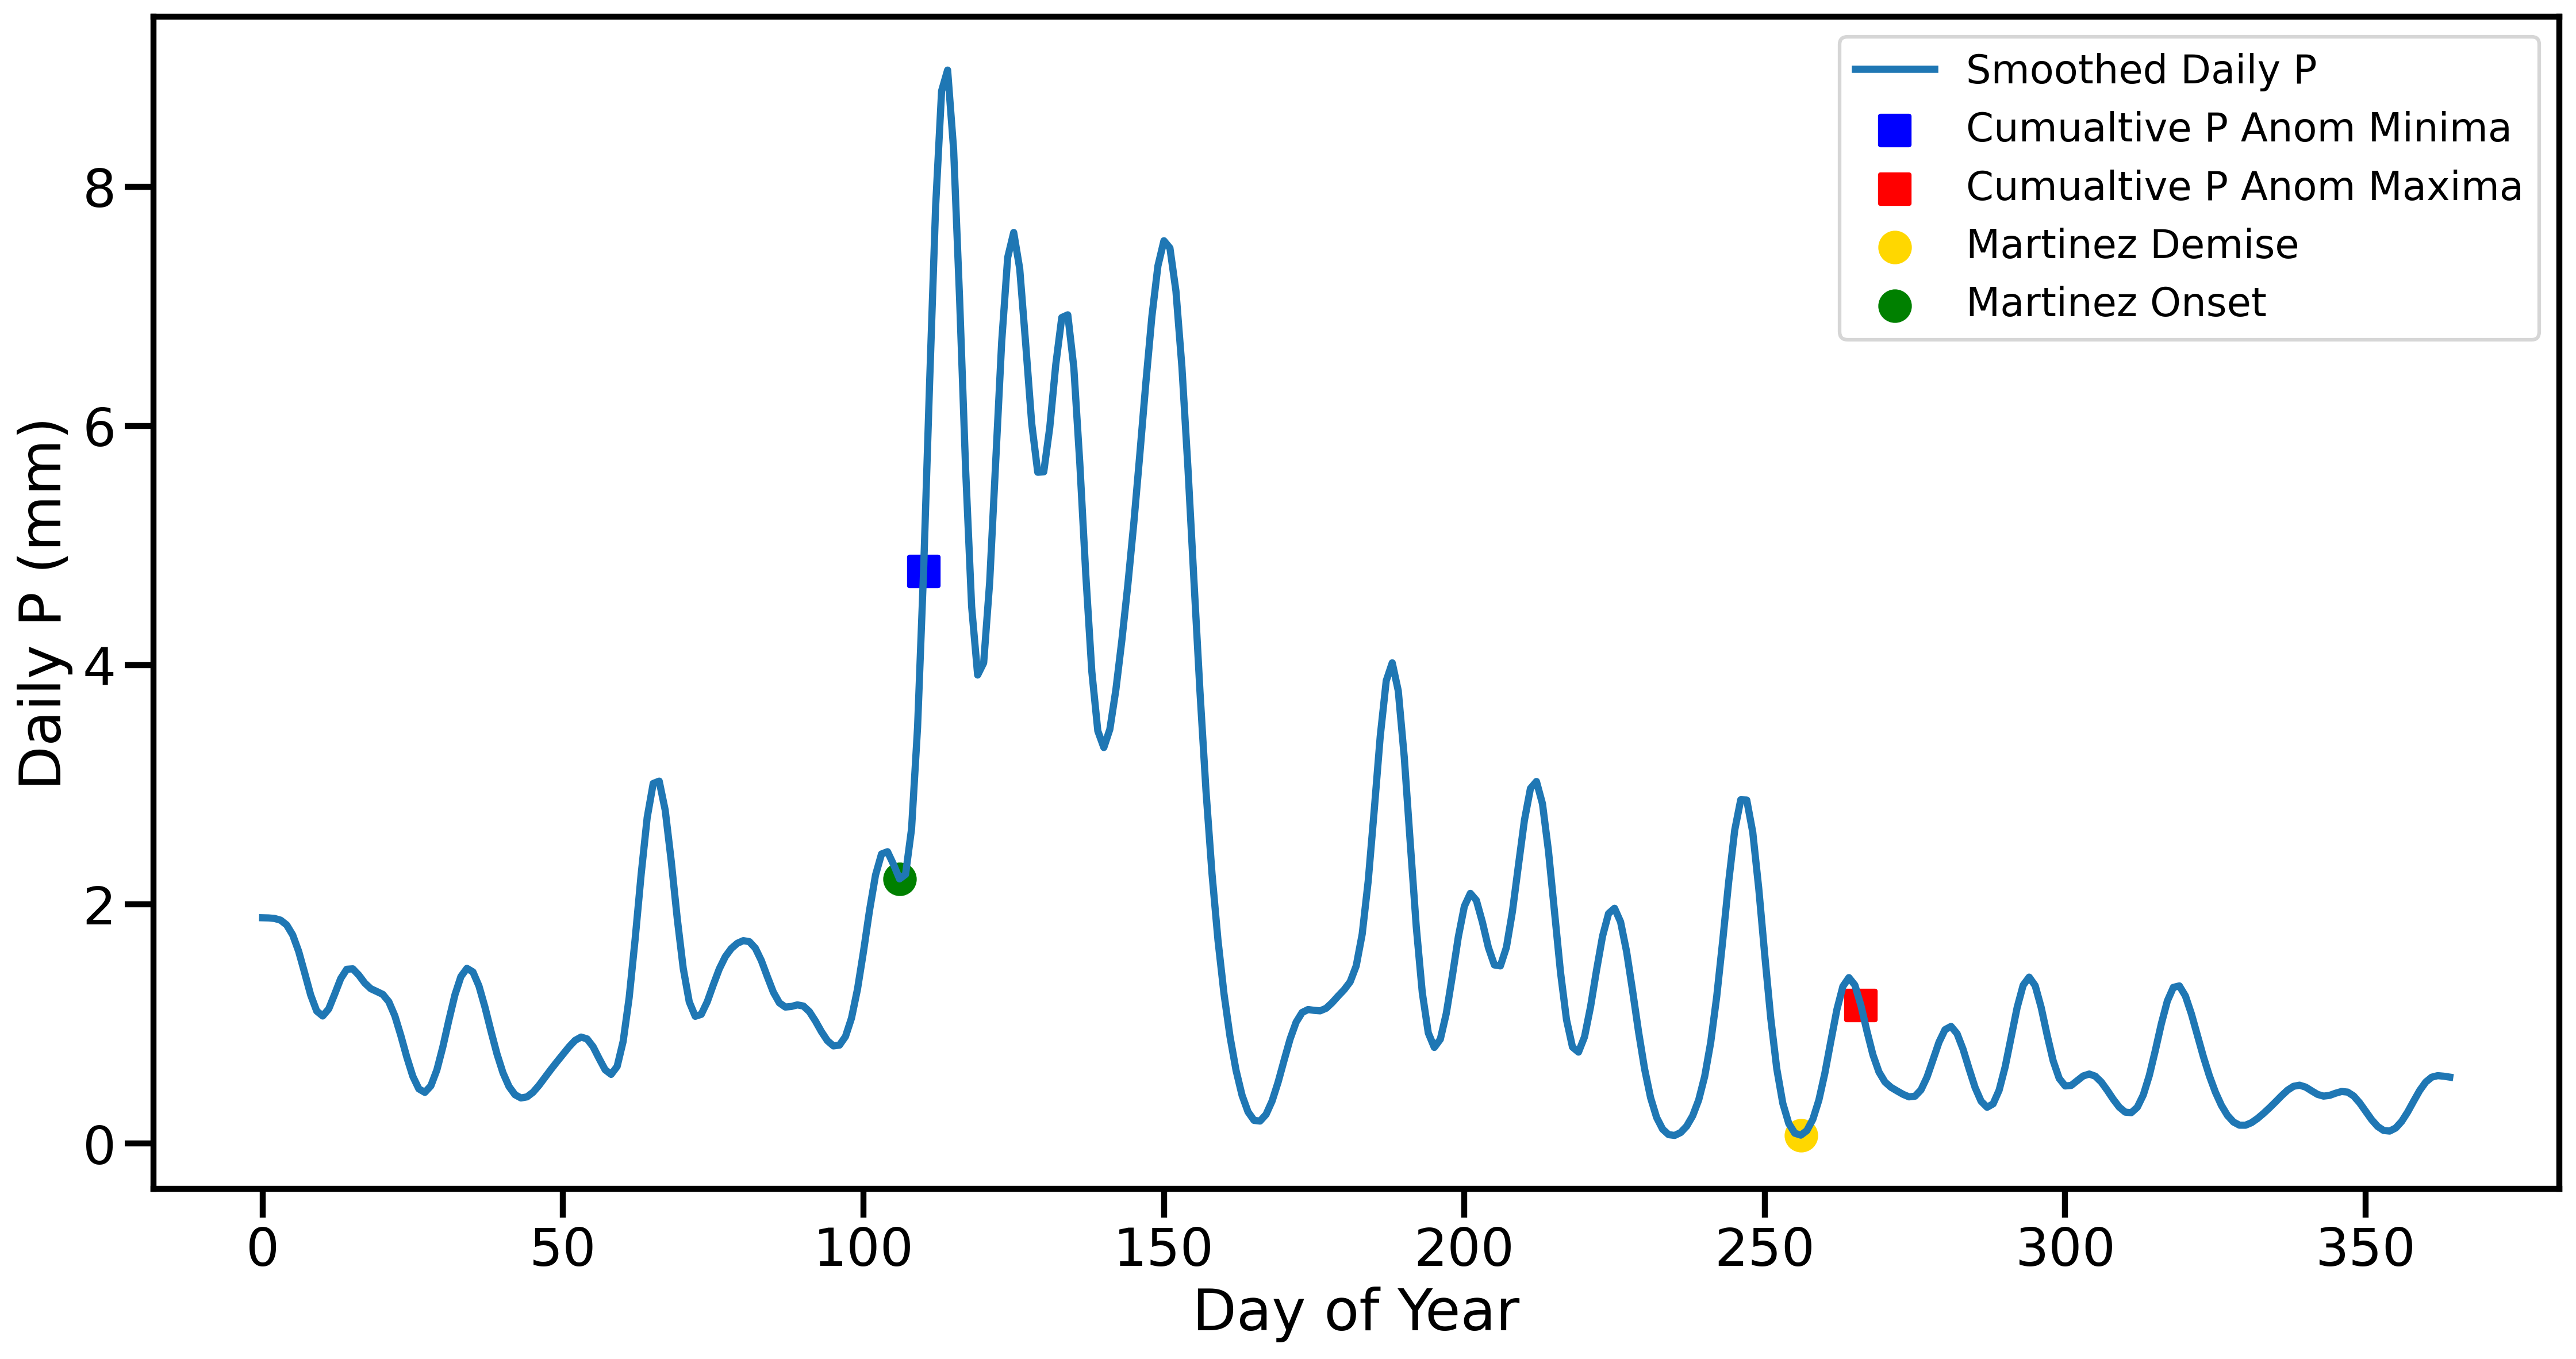

In [23]:
sns.set_context('poster')
#dataPoint = precip.sel(latitude=lat, longitude=lon)
bonset = int(bombardi.sel(latitude=lat, longitude=lon, year='2011')['onset_doy'].values[0])
bdemise = int(bombardi.sel(latitude=lat, longitude=lon, year='2011')['demise_doy'].values[0])

monset = int(martinez.sel(latitude=lat, longitude=lon, year='2011')['onset_doy'].values[0])
mdemise = int(martinez.sel(latitude=lat, longitude=lon, year='2011')['demise_doy'].values[0])
fig, ax = plt.subplots(1,1, figsize = (18, 9), dpi = 300)
plt.plot(dataFiltered, label='Smoothed Daily P')

plt.scatter(bonset,dataFiltered[bonset], color='blue', marker="s", label='Cumualtive P Anom Minima')
plt.scatter(bdemise,dataFiltered[bdemise],color='red', marker='s', label='Cumualtive P Anom Maxima')
plt.scatter(mdemise,dataFiltered[mdemise], color='gold', label='Martinez Demise')
plt.scatter(monset,dataFiltered[monset],color='green',label='Martinez Onset')
ax.set_ylabel('Daily P (mm)')
ax.set_xlabel('Day of Year')
#plt.axhline(np.quantile(dataFiltered,.30), color='black', label='20th percentile')
sns.set_context('talk')
plt.legend()
plt.savefig('martinez.png',figsize = (18, 9), dpi = 300)